# Canopy Height Map in Dak Lak (Viet Nam) based on GEDI, Sentinel-1 and Sentinel-2 data

## 1. Importing packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

## 2. Data Visualization

### Reading data

In [5]:
df = pd.read_csv("/root/DakLak_train.csv")
df = df.drop(columns=["Unnamed: 0"])
df.head()

rh95  VV_ascending  VH_ascending  VV_descending  VH_descending      B2  \
0  6.81      0.809576      0.555072       0.754617       0.538162  0.0872   
1  5.58      0.781447      0.514036       0.743520       0.524570  0.0796   
2  4.08      0.723803      0.523775       0.888992       0.534329  0.1148   
3  4.00      0.792703      0.528495       0.769668       0.549678  0.1170   
4  3.29      0.771674      0.535143       0.787137       0.482735  0.1289   

       B3      B4      B5      B6      B7      B8     B8A     B11     B12  
0  0.1167  0.0872  0.1975  0.4834  0.5855  0.5853  0.6448  0.3873  0.2224  
1  0.1177  0.0937  0.2252  0.4651  0.5500  0.5871  0.6052  0.4453  0.2693  
2  0.1571  0.1647  0.2531  0.4358  0.5061  0.5370  0.5442  0.4574  0.3279  
3  0.1582  0.1504  0.2454  0.4933  0.5486  0.5945  0.6054  0.4322  0.3012  
4  0.1682  0.2024  0.2998  0.4479  0.4662  0.5234  0.4774  0.4827  0.3694

### Basic properties of label

In [401]:
print("Number of samples: ", len(df))
print("Label details:")
df['rh95'].describe()

Number of samples:  134610
Label details:


count    134610.000000
mean          9.916408
std           8.843865
min           1.830000
25%           3.060000
50%           6.290000
75%          14.550000
max          51.669998
Name: rh95, dtype: float64

### Label histogram

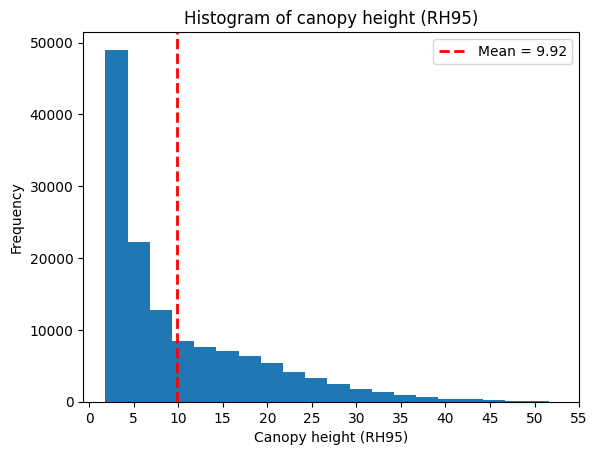

In [312]:
plt.hist(df['rh95'], bins=20)

xmin = df['rh95'].min()
xmax = df['rh95'].max()

plt.xticks(np.arange(0, xmax + 5, 5))
mean_val = df['rh95'].mean()
plt.axvline(mean_val, linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}", c='r')
plt.xlabel("Canopy height (RH95)")
plt.ylabel("Frequency")
plt.title("Histogram of canopy height (RH95)")
plt.legend()
plt.show()

### Label density

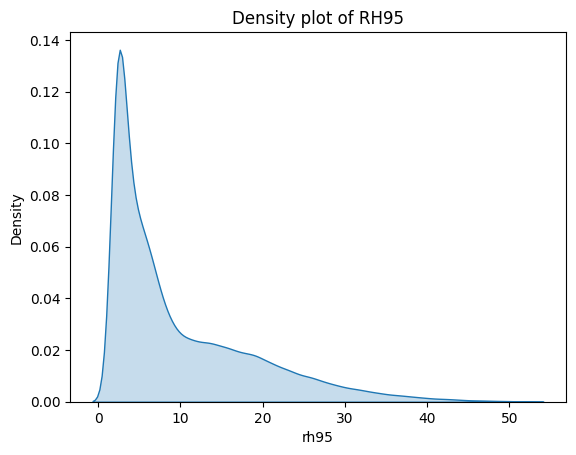

In [313]:
sns.kdeplot(df['rh95'], fill=True)
plt.title("Density plot of RH95")
plt.show()


## Correlation between features and label

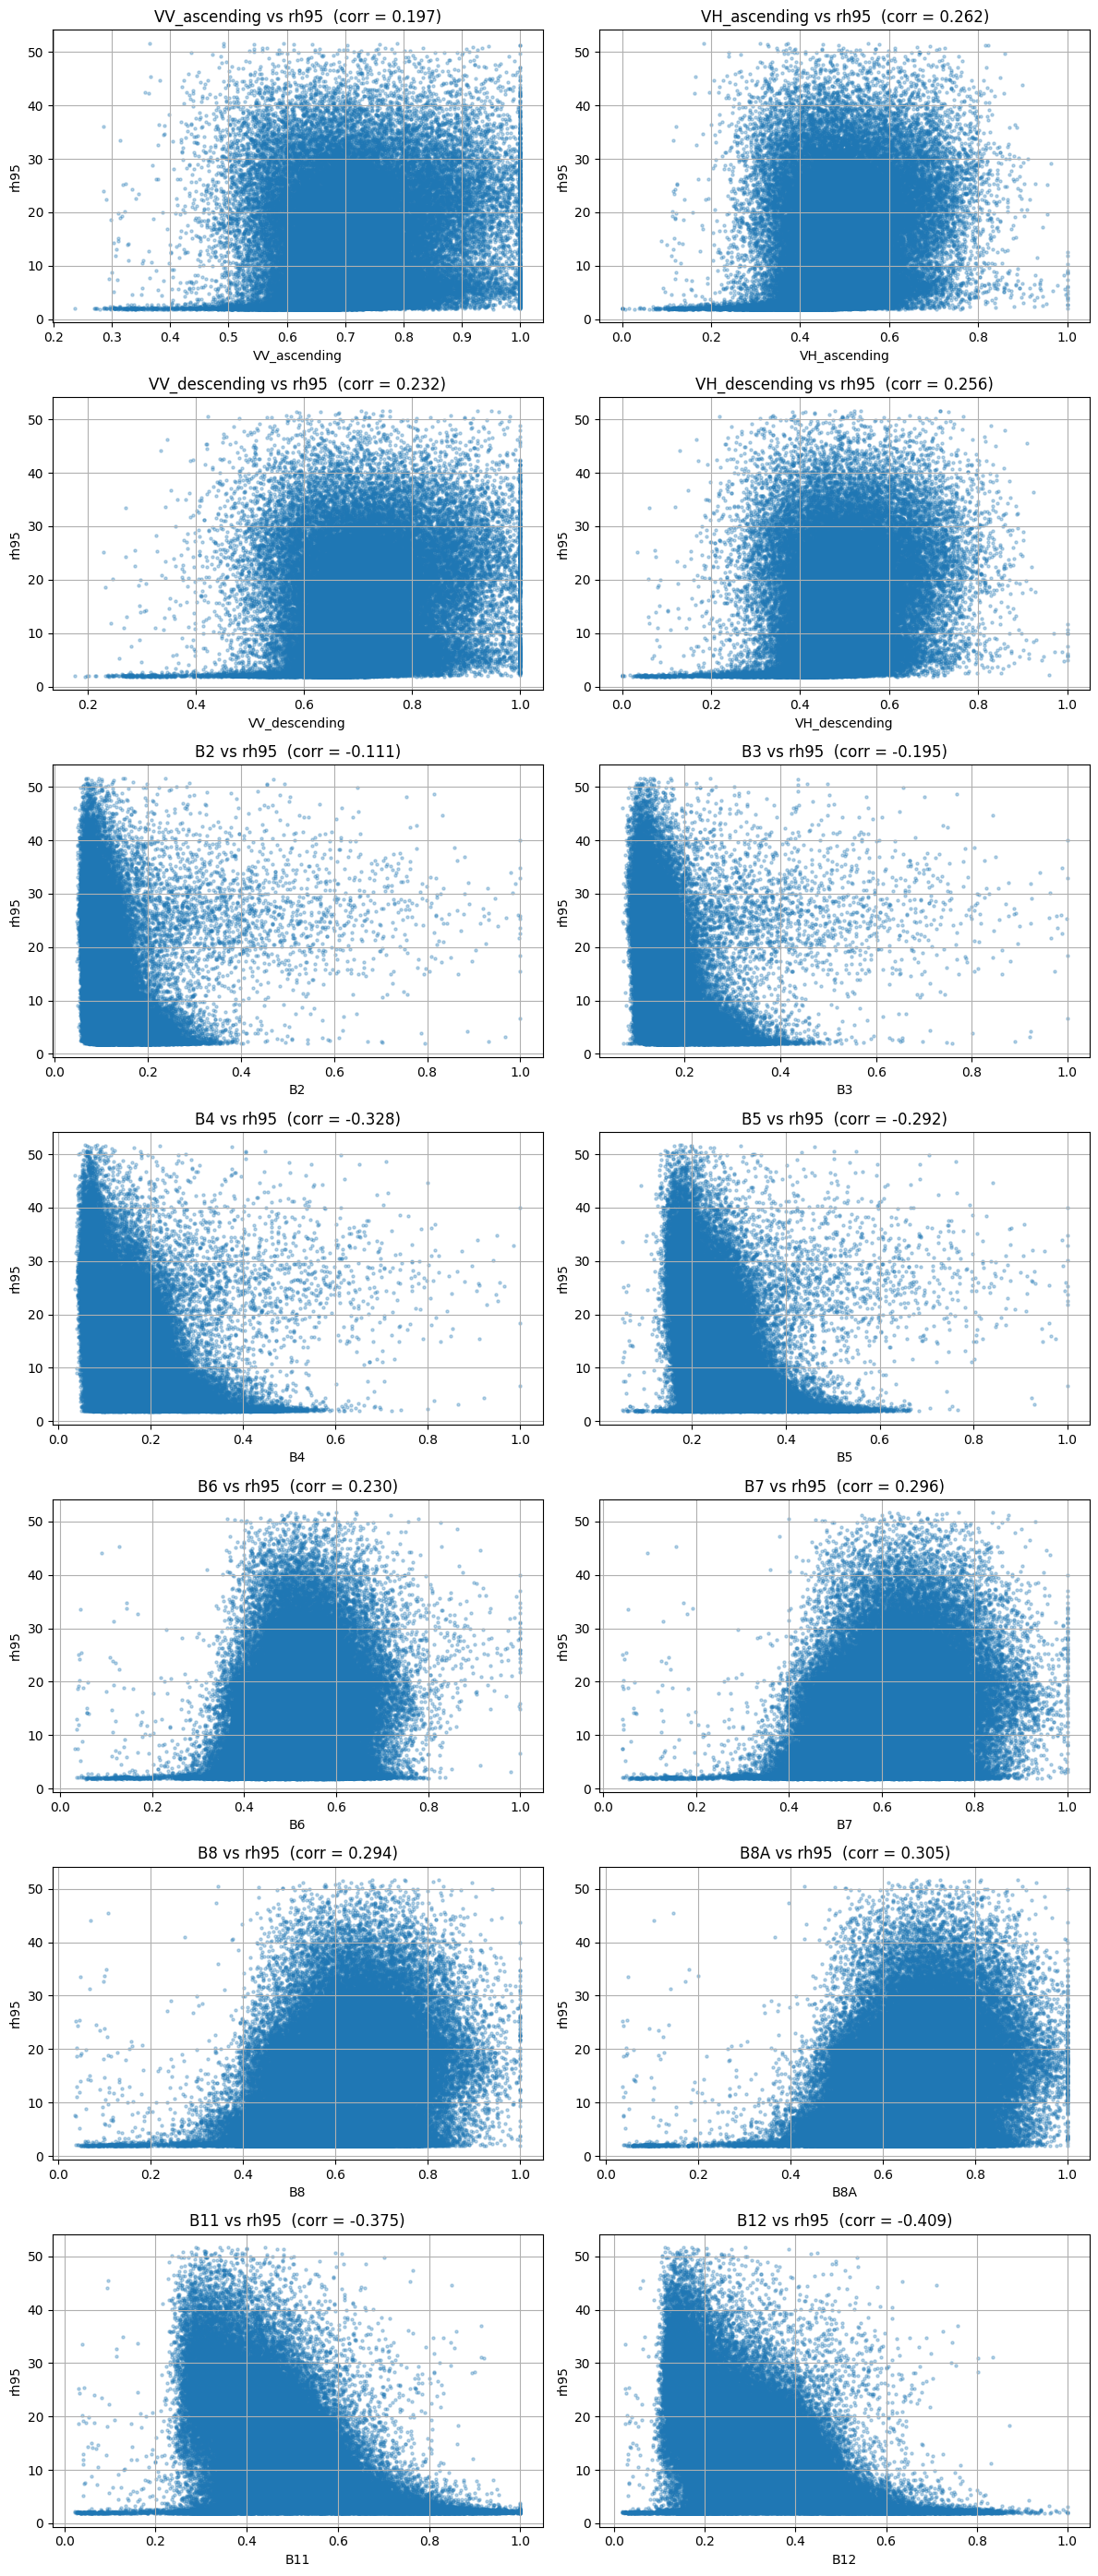

In [314]:
target = 'rh95'
features = [col for col in df.columns if col != target]

n_features = len(features)
cols = 2
rows = int(np.ceil(n_features / cols))

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()

for i, col in enumerate(features):
    ax = axes[i]

    r = df[[target, col]].corr().iloc[0, 1]

    ax.scatter(df[col], df[target], alpha=0.3, s=5)
    ax.set_xlabel(col)
    ax.set_ylabel(target)
    ax.set_title(f"{col} vs {target}  (corr = {r:.3f})")
    ax.grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Correlation heat map

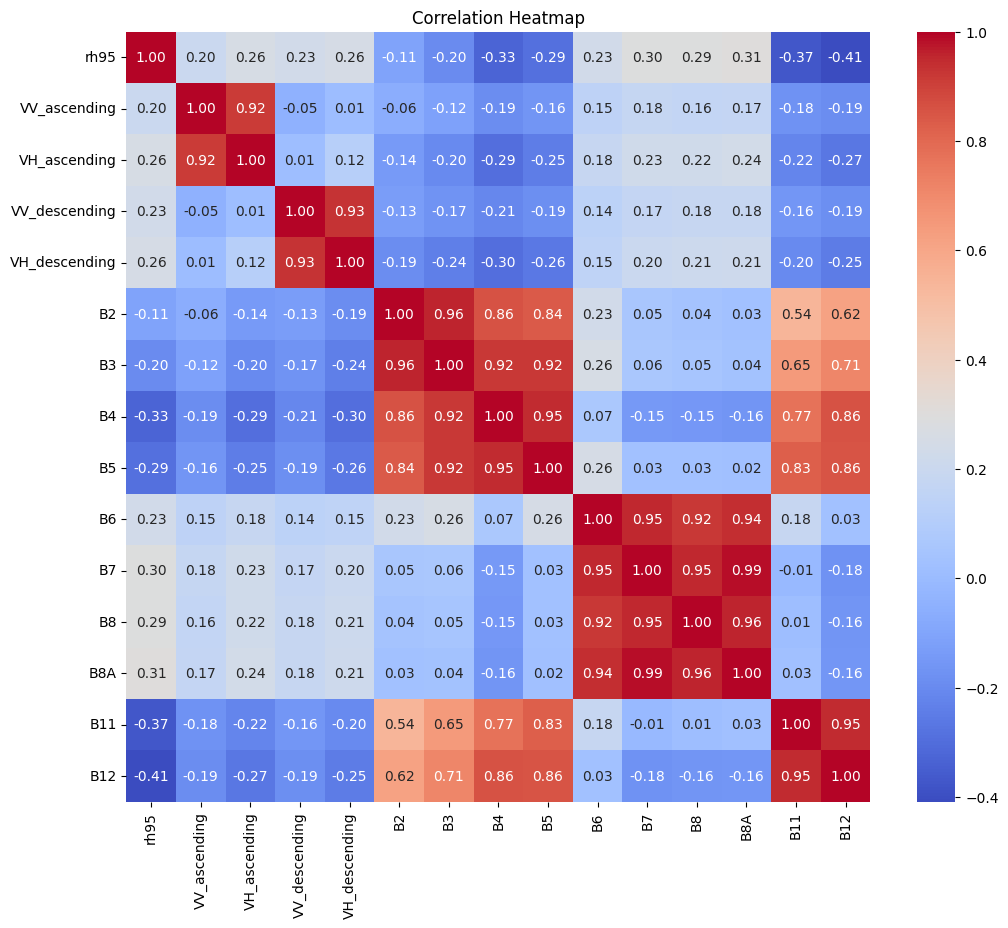

In [315]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


### Box plot

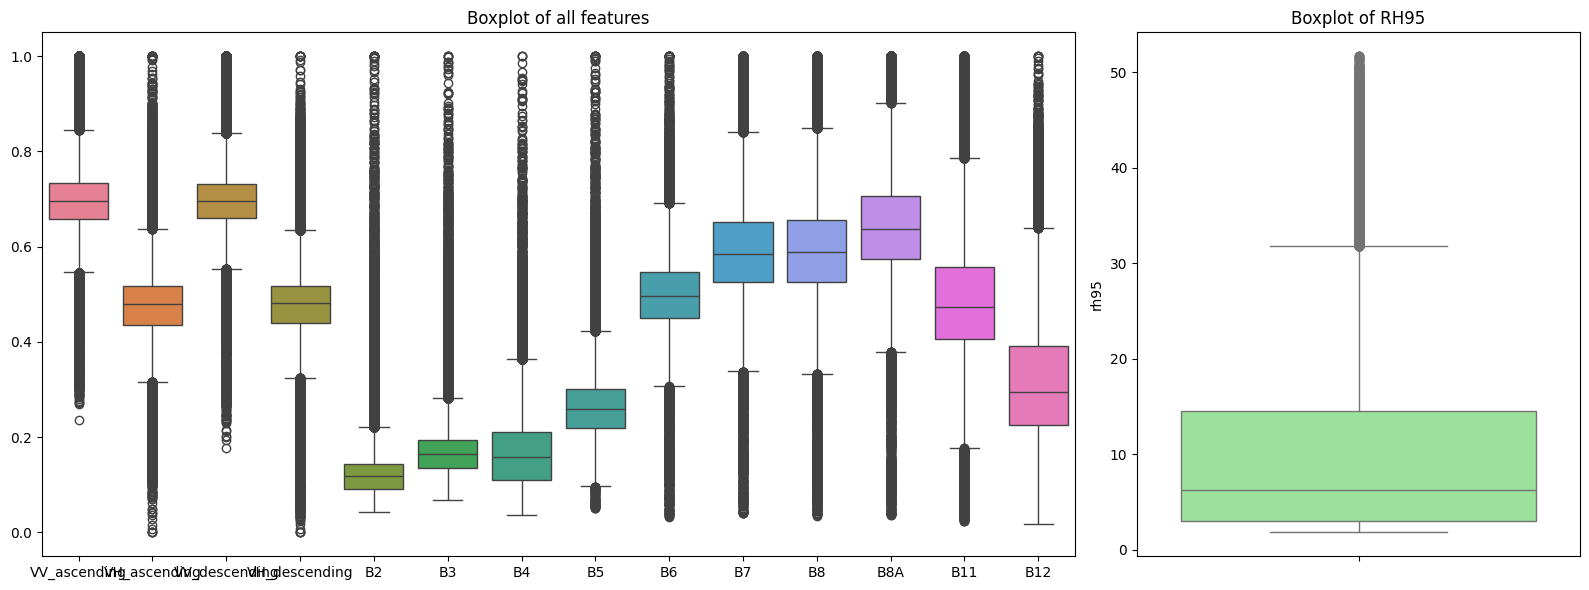

In [316]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16,6))
gs = GridSpec(1, 2, width_ratios=[7, 3], figure=fig)

ax0 = fig.add_subplot(gs[0])
sns.boxplot(data=df.drop(columns=['rh95']), ax=ax0)
ax0.set_title("Boxplot of all features")

ax1 = fig.add_subplot(gs[1])
sns.boxplot(y=df['rh95'], ax=ax1, color='lightgreen')
ax1.set_title("Boxplot of RH95")

plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [402]:
df['VH_to_VV_asc'] = df['VH_ascending'] / df['VV_ascending'] 
df['VH_to_VV_desc'] = df['VH_descending'] / df['VV_descending'] 
df['VV_diff'] = df['VV_ascending'] - df['VV_descending']
df['VH_diff'] = df['VH_ascending'] - df['VH_descending']
df['VV_mean'] = df[['VV_ascending','VV_descending']].mean(axis=1) 
df['VH_mean'] = df[['VH_ascending','VH_descending']].mean(axis=1)
df['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4'])
df['EVI'] = 2.5 * (df['B8'] - df['B4']) / (df['B8'] + 6*df['B4'] - 7.5*df['B2'] + 1)
df['SAVI'] = ((df['B8'] - df['B4']) * (1 + 0.5)) / (df['B8'] + df['B4'] + 0.5)
df['GNDVI'] = (df['B8'] - df['B3']) / (df['B8'] + df['B3'])
df['MSAVI'] = (2 * df['B8'] + 1 - ((2 * df['B8'] + 1)**2 - 8 * (df['B8'] - df['B4']))**0.5) / 2

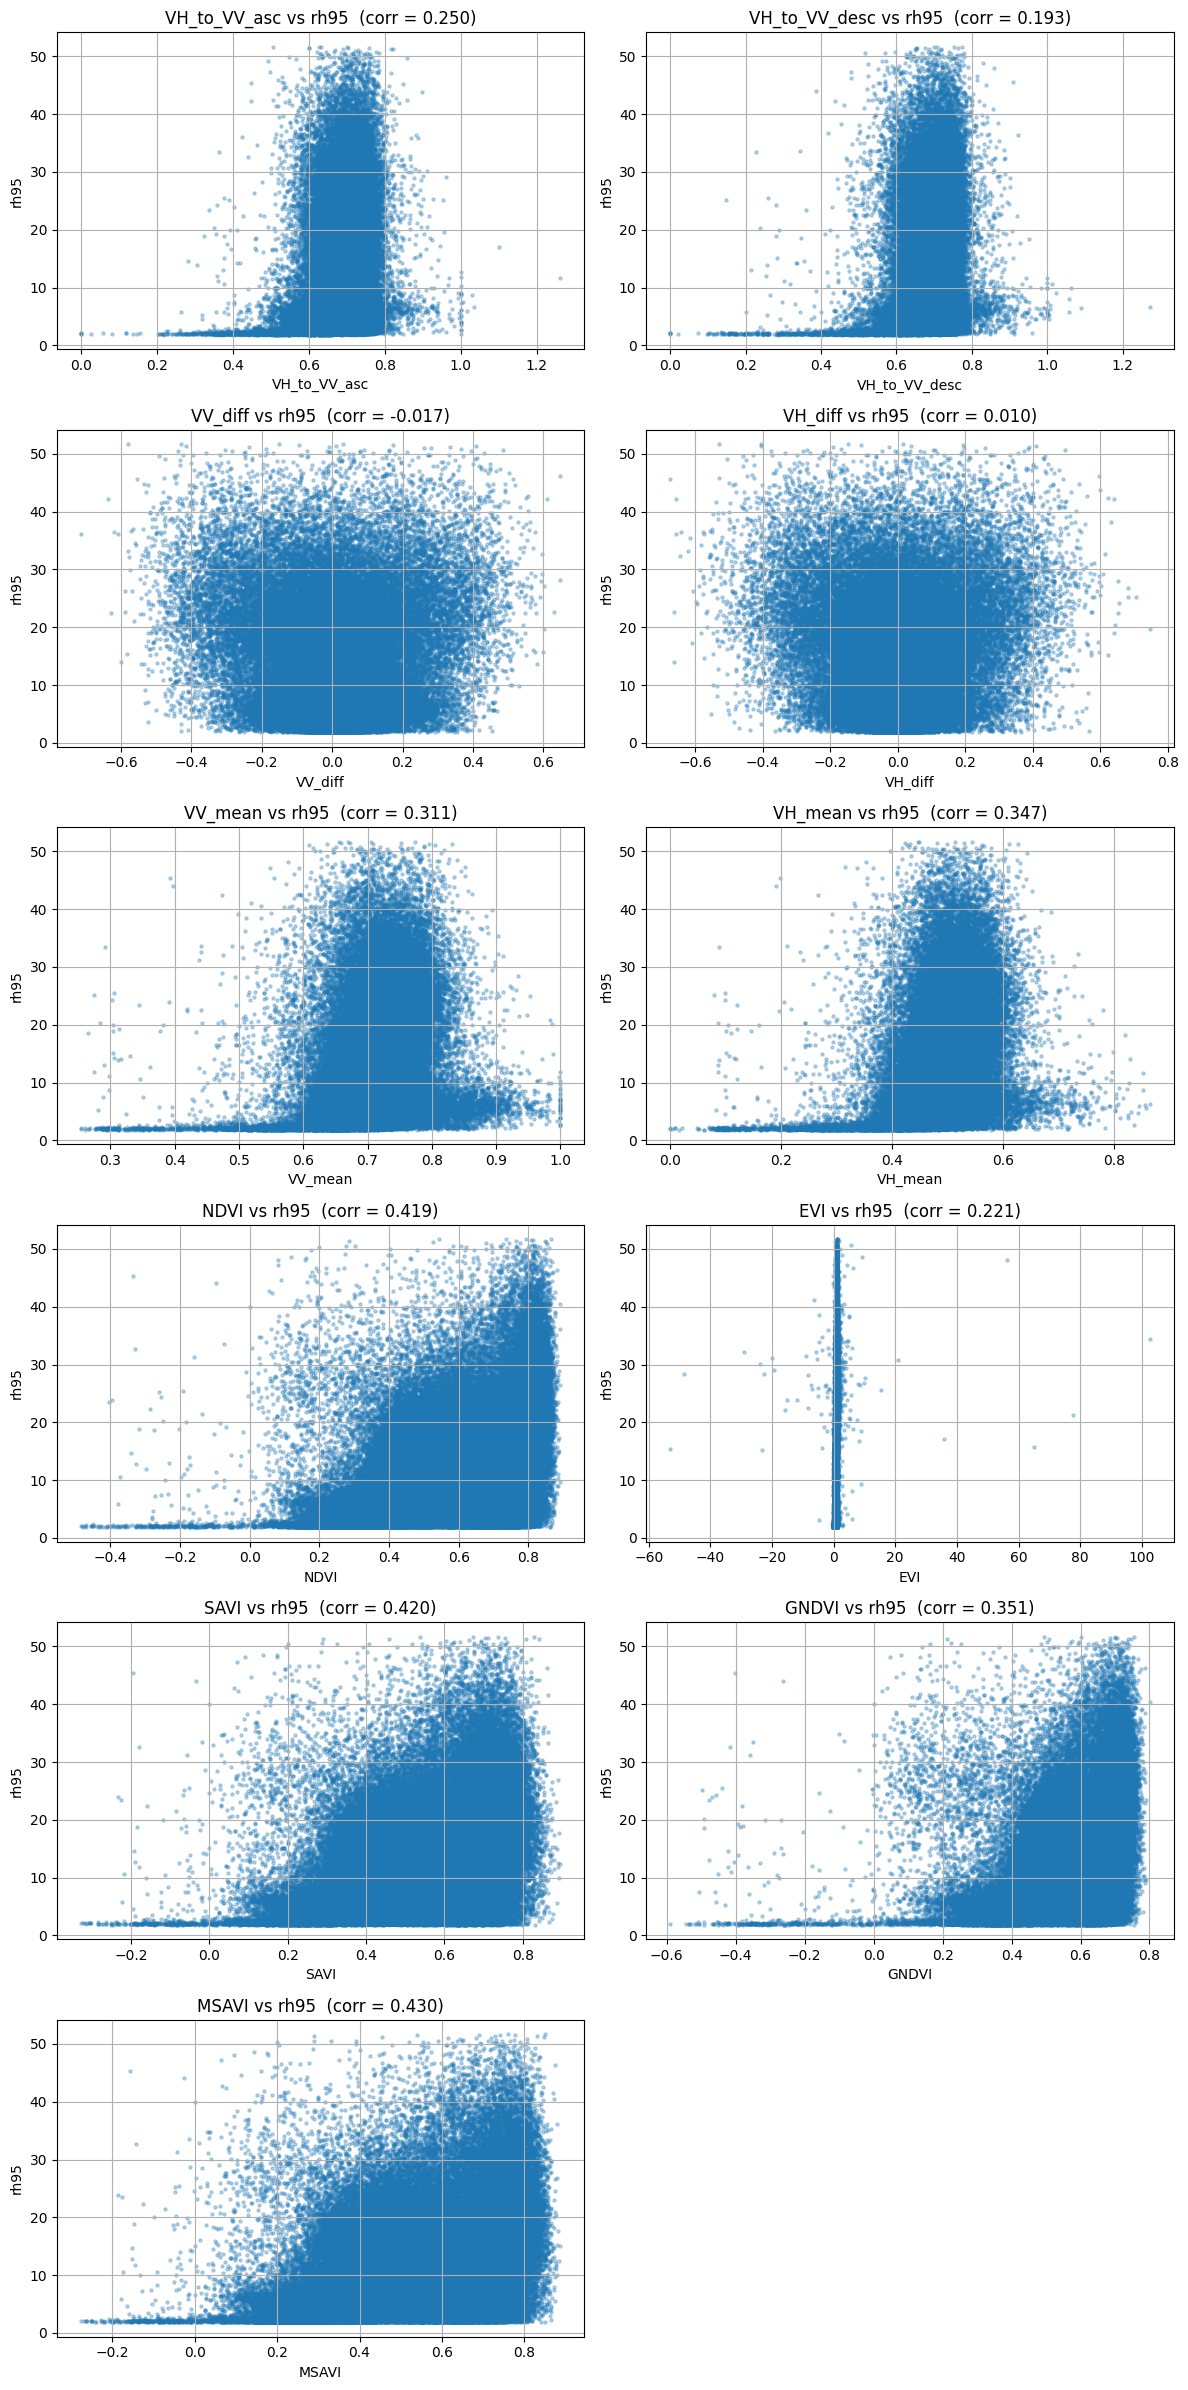

In [318]:
target = 'rh95'
features = [
    'VH_to_VV_asc',
    'VH_to_VV_desc',
    'VV_diff',
    'VH_diff',
    'VV_mean',
    'VH_mean',
    'NDVI',
    'EVI',
    'SAVI',
    'GNDVI',
    'MSAVI'
]

n_features = len(features)
cols = 2
rows = int(np.ceil(n_features / cols))

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()

for i, col in enumerate(features):
    ax = axes[i]

    r = df[[target, col]].corr().iloc[0, 1]

    ax.scatter(df[col], df[target], alpha=0.3, s=5)
    ax.set_xlabel(col)
    ax.set_ylabel(target)
    ax.set_title(f"{col} vs {target}  (corr = {r:.3f})")
    ax.grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 4. Training Machine Learning Models

### 4.1. LGBRegressor

In [338]:
corr_with_target = df.corr()['rh95']
# Features with low correlation
low_corr_features = corr_with_target[corr_with_target.abs() < 0].index.tolist()
low_corr_features

[]

In [339]:
df_train = df.drop(low_corr_features, axis=1)

In [373]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import lightgbm as lgb
import numpy as np

# Prepare training data
X = df_train.drop('rh95', axis=1)
y = df_train['rh95']

# Define model
model = lgb.LGBMRegressor(device='gpu', n_jobs=-1)

# Define hyperparameter grid
param_grid = {
    'num_leaves': [63, 127, 256],
    'max_depth': [12, 16, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 900, 1200],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Use RMSE as scoring
mae_score = make_scorer(lambda y_true, y_pred: mean_absolute_error(y_true, y_pred), greater_is_better=False)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring=mae_score, 
    cv=5,
    verbose=2,
    random_state=42,
    refit=True
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best CV MAE:", -random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 107688, number of used features: 25


[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 5060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (2.88 MB) transferred to GPU in 0.007570 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 9.436694
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=16, min_child_samples=20, n_estimators=900, num_leaves=63, subsample=0.8; total time=   5.7s
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 107688, number of used features: 25
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 5060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info

In [390]:
df = pd.read_csv("/root/DakLak_train.csv")
df = df.drop(columns=["Unnamed: 0"])

X = df.drop(["rh95", "B8"], axis=1)
y = df['rh95']

In [374]:
model = random_search.best_estimator_
model

LGBMRegressor(colsample_bytree=0.7, device='gpu', learning_rate=0.01,
              max_depth=20, min_child_samples=5, n_estimators=1200, n_jobs=-1,
              num_leaves=256)

In [375]:
df_test = pd.read_csv("/root/DakLak_test.csv")
df_test = df_test.drop(columns=["Unnamed: 0"])
df_test['VH_to_VV_asc'] = df_test['VH_ascending'] / df_test['VV_ascending'] 
df_test['VH_to_VV_desc'] = df_test['VH_descending'] / df_test['VV_descending'] 
df_test['VV_diff'] = df_test['VV_ascending'] - df_test['VV_descending']
df_test['VH_diff'] = df_test['VH_ascending'] - df_test['VH_descending']
df_test['VV_mean'] = df_test[['VV_ascending','VV_descending']].mean(axis=1) 
df_test['VH_mean'] = df_test[['VH_ascending','VH_descending']].mean(axis=1)
df_test['NDVI'] = (df_test['B8'] - df_test['B4']) / (df_test['B8'] + df_test['B4'])
df_test['EVI'] = 2.5 * (df_test['B8'] - df_test['B4']) / (df_test['B8'] + 6*df_test['B4'] - 7.5*df_test['B2'] + 1)
df_test['SAVI'] = ((df_test['B8'] - df_test['B4']) * (1 + 0.5)) / (df_test['B8'] + df_test['B4'] + 0.5)
df_test['GNDVI'] = (df_test['B8'] - df_test['B3']) / (df_test['B8'] + df_test['B3'])
df_test['MSAVI'] = (2 * df_test['B8'] + 1 - ((2 * df_test['B8'] + 1)**2 - 8 * (df_test['B8'] - df_test['B4']))**0.5) / 2
df_test = df_test.drop(low_corr_features, axis=1)
X_test = df_test.drop('rh95', axis=1)
y_test = df_test['rh95']
y_pred = model.predict(X_test)
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", root_mean_squared_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))


MAE:  3.609890637150102
RMSE:  5.428904448524977
R2:  0.6760786599935995


### 4.2. XGBoost

In [377]:
import xgboost as xgb

param_dist = {
    'n_estimators': [500, 800, 1000, 1200],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Use RMSE as the scoring metric
mae_score = make_scorer(lambda y_true, y_pred: mean_absolute_error(y_true, y_pred), greater_is_better=False)

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1
)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=mae_score,
    cv=5,
    verbose=2,
    random_state=42,
    refit=True
)

random_search.fit(X, y)
print("Best parameters:", random_search.best_params_)
print("Best CV MAE:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=1200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=  13.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=1200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=  13.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=1200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=  13.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=1200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=  13.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=1200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=  13.8s
[CV] END colsample_bytree=1.0, gamma=0.5, learni

In [378]:
model = random_search.best_estimator_
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=7, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [380]:
y_pred = model.predict(X_test)
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", root_mean_squared_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))


MAE:  3.60657236825847
RMSE:  5.4423384136395185
R2:  0.6744735729886302


### 4.3. Random Forest

In [325]:
from sklearn.ensemble import RandomForestRegressor

# Initialize model
rf = RandomForestRegressor(
    n_estimators=200,   # number of trees
    max_depth=15,
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
    max_features='sqrt',
    verbose=1
)

# Train
rf.fit(X, y)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   17.8s finished


RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      n_jobs=-1, random_state=42, verbose=1)

In [326]:
# Make predictions
y_pred = rf.predict(X)

# Evaluate
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", root_mean_squared_error(y, y_pred))
print("R2:", r2_score(y, y_pred))

[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.1s


MAE: 3.481292764448733
RMSE: 4.7981947674008145
R2: 0.7056427017083933


[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    0.3s
[Parallel(n_jobs=11)]: Done 200 out of 200 | elapsed:    0.3s finished


In [327]:
y_pred = rf.predict(X_test)
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", root_mean_squared_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))


MAE:  3.850971915780239
RMSE:  5.664533885301627
R2:  0.6473502967605789


[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    0.1s
[Parallel(n_jobs=11)]: Done 200 out of 200 | elapsed:    0.1s finished


## 5. Training Deep Learning Models

In [15]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
print("Version: ", torch.__version__)

Device:  cuda
Version:  2.10.0.dev20251122+cu128


In [11]:
df = pd.read_csv("/root/DakLak_train.csv")
df = df.drop(columns=["Unnamed: 0"])

df_test = pd.read_csv("/root/DakLak_test.csv")
df_test = df_test.drop(columns=["Unnamed: 0"])

In [77]:
df['VH_to_VV_asc'] = df['VH_ascending'] / df['VV_ascending'] 
df['VH_to_VV_desc'] = df['VH_descending'] / df['VV_descending'] 
df['VV_diff'] = df['VV_ascending'] - df['VV_descending']
df['VH_diff'] = df['VH_ascending'] - df['VH_descending']
df['VV_mean'] = df[['VV_ascending','VV_descending']].mean(axis=1) 
df['VH_mean'] = df[['VH_ascending','VH_descending']].mean(axis=1)
df['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4'])
df['EVI'] = 2.5 * (df['B8'] - df['B4']) / (df['B8'] + 6*df['B4'] - 7.5*df['B2'] + 1)
df['SAVI'] = ((df['B8'] - df['B4']) * (1 + 0.5)) / (df['B8'] + df['B4'] + 0.5)
df['GNDVI'] = (df['B8'] - df['B3']) / (df['B8'] + df['B3'])
df['MSAVI'] = (2 * df['B8'] + 1 - ((2 * df['B8'] + 1)**2 - 8 * (df['B8'] - df['B4']))**0.5) / 2

In [78]:
df_test['VH_to_VV_asc'] = df_test['VH_ascending'] / df_test['VV_ascending'] 
df_test['VH_to_VV_desc'] = df_test['VH_descending'] / df_test['VV_descending'] 
df_test['VV_diff'] = df_test['VV_ascending'] - df_test['VV_descending']
df_test['VH_diff'] = df_test['VH_ascending'] - df_test['VH_descending']
df_test['VV_mean'] = df_test[['VV_ascending','VV_descending']].mean(axis=1) 
df_test['VH_mean'] = df_test[['VH_ascending','VH_descending']].mean(axis=1)
df_test['NDVI'] = (df_test['B8'] - df_test['B4']) / (df_test['B8'] + df_test['B4'])
df_test['EVI'] = 2.5 * (df_test['B8'] - df_test['B4']) / (df_test['B8'] + 6*df_test['B4'] - 7.5*df_test['B2'] + 1)
df_test['SAVI'] = ((df_test['B8'] - df_test['B4']) * (1 + 0.5)) / (df_test['B8'] + df_test['B4'] + 0.5)
df_test['GNDVI'] = (df_test['B8'] - df_test['B3']) / (df_test['B8'] + df_test['B3'])
df_test['MSAVI'] = (2 * df_test['B8'] + 1 - ((2 * df_test['B8'] + 1)**2 - 8 * (df_test['B8'] - df_test['B4']))**0.5) / 2

In [79]:
X_train = torch.from_numpy(df.drop("rh95", axis=1).to_numpy()).float()
y_train = torch.from_numpy(df["rh95"].to_numpy()).float()

X_test  = torch.from_numpy(df_test.drop("rh95", axis=1).to_numpy()).float()
y_test  = torch.from_numpy(df_test["rh95"].to_numpy()).float()


In [97]:

train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False
)

In [98]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    
    def forward(self, x):
        return self.layer(x)

In [99]:
model = NeuralNetwork(input_shape=len(df.columns)-1).to(device)
model

NeuralNetwork(
  (layer): Sequential(
    (0): Linear(in_features=25, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [100]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [101]:
def train(model, loss_fn, optimizer, train_data_batch, test_data_batch, epochs=100):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in train_data_batch:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred.squeeze(), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        model.eval()
        test_loss = 0
        with torch.inference_mode():
            for x, y in test_data_batch:
                x, y = x.to(device), y.to(device)
                y_pred_test = model(x)
                loss = loss_fn(y_pred_test.squeeze(-1), y)
                test_loss += loss.item()
        train_loss /= len(train_data_batch)
        test_loss /= len(test_data_batch)
        print(f"Epoch: {epoch} | Train loss: {train_loss} | Test loss: {test_loss}")

In [102]:
train(model, loss_fn, optimizer, train_loader, test_loader)

Epoch: 0 | Train loss: 4.928516831688102 | Test loss: 4.8705969905843425
Epoch: 1 | Train loss: 4.616957108330817 | Test loss: 4.292328415216346
Epoch: 2 | Train loss: 4.4821915499611045 | Test loss: 4.145816371053709
Epoch: 3 | Train loss: 4.432391465390136 | Test loss: 4.141128276122454
Epoch: 4 | Train loss: 4.328015327453613 | Test loss: 4.08136200682977
Epoch: 5 | Train loss: 4.222706942050629 | Test loss: 3.9717154752956136
Epoch: 6 | Train loss: 4.180151360116531 | Test loss: 3.9169118214768757
Epoch: 7 | Train loss: 4.142954529011657 | Test loss: 3.8808704910423812
Epoch: 8 | Train loss: 4.093543887138367 | Test loss: 3.7948659899041584
Epoch: 9 | Train loss: 4.068564795722526 | Test loss: 3.789267471798647
Epoch: 10 | Train loss: 4.030671447402171 | Test loss: 3.80067326748124
Epoch: 11 | Train loss: 4.01638998867441 | Test loss: 3.727029593959776
Epoch: 12 | Train loss: 3.978036553687469 | Test loss: 3.7750006575949864
Epoch: 13 | Train loss: 3.9672463860348604 | Test loss: 3

KeyboardInterrupt: 